In [1]:
using LinearAlgebra
using Plots

In [2]:
function defaultDot(G::Matrix{Float64}, H::Matrix{Float64})::Matrix{Float64}
    a = size(G, 1)
    b = size(G, 2)
    c = size(H, 2)

    R = Matrix{Float64}(zeros(a, c))

    for i in 1:a
        for j in 1:b
            for k in 1:c
                R[i, k] += G[i, j] * H[j, k]
            end
        end
    end

    return R
end

defaultDot (generic function with 1 method)

In [3]:
function VinogradDot(G::Matrix{Float64}, H::Matrix{Float64})::Matrix{Float64}
    a = size(G, 1)
    b = size(G, 2)
    c = size(H, 2)

    d = Integer(b / 2)
    rowFactor = Vector{Float64}(undef, a)
    columnFactor = Vector{Float64}(undef, c)

    for i in 1:a
        rowFactor[i] = G[i, 1] * G[i, 2]
        for j in 2:d
            rowFactor[i] += G[i, 2 * j - 1] * G[i, 2 * j]
        end
    end

    for i in 1:c
        columnFactor[i] = H[1, i] * H[2, i]
        for j in 2:d
            columnFactor[i] += H[2 * j - 1, i] * H[2 * j, i]
        end
    end

    R = Matrix{Float64}(undef, a, c)
    for i in 1:a
        for j in 1:c
            R[i, j] = -rowFactor[i] - columnFactor[j]
            for k in 1:d
                R[i, j] += (G[i, 2 * k - 1] + H[2 * k, j]) * (G[i, 2 * k] + H[2 * k - 1, j])
            end
        end
    end

    if (b % 2 == 1)
        for i in 1:a
            for j in 1:c
                R[i, j] += G[i, b] * H[b, j]
            end
        end
    end

    return R
end

VinogradDot (generic function with 1 method)

In [4]:
function ShtrassenDot(G_::Matrix{Float64}, H_::Matrix{Float64})::Matrix{Float64}
    a = size(G_, 1)
    b = size(G_, 2)
    c = size(H_, 2)

    if (b < 64)
        return defaultDot(G_, H_)
    end

    N = nextpow(2, max(a, b, c))

    G = Matrix{Float64}(zeros(N, N))
    H = Matrix{Float64}(zeros(N, N))
    G[1:a, 1:b] .= G_
    H[1:b, 1:c] .= H_

    d = Integer(N / 2)

    G11 = G[  1:d,   1:d]
    G12 = G[  1:d, d+1:N]
    G21 = G[d+1:N,   1:d]
    G22 = G[d+1:N, d+1:N]
    
    H11 = H[  1:d,   1:d]
    H12 = H[  1:d, d+1:N]
    H21 = H[d+1:N,   1:d]
    H22 = H[d+1:N, d+1:N]
    
    x1 = ShtrassenDot(G11 + G22,    H11 + H22)
    x2 = ShtrassenDot(G21 + G22,    H11)
    x3 = ShtrassenDot(G11,          H12 - H22)
    x4 = ShtrassenDot(G22,          H21 - H11)
    x5 = ShtrassenDot(G11 + G12,    H22)
    x6 = ShtrassenDot(G21 - G11,    H11 + H12)
    x7 = ShtrassenDot(G12 - G22,    H21 + H22)

    R = Matrix{Float64}(undef, N, N)

    R[  1:d,   1:d] .= x1 + x4 - x5 + x7
    R[  1:d, d+1:N] .= x3 + x5
    R[d+1:N,   1:d] .= x2 + x4
    R[d+1:N, d+1:N] .= x1 - x2 + x3 + x6

    return R[1:a, 1:c]
end

ShtrassenDot (generic function with 1 method)

2
4
8
16
32
64
128
256
512
1024
2048


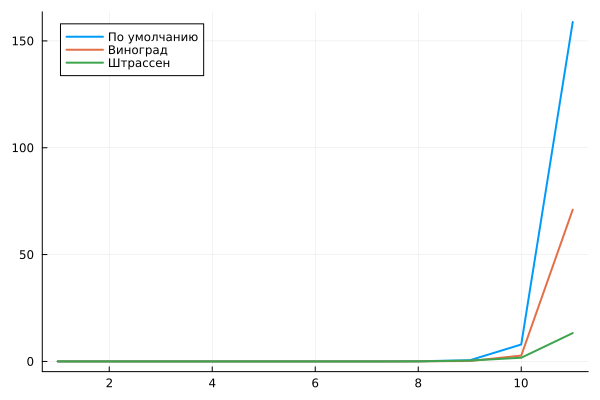

In [5]:
two_pows = [2^i for i in 1:11]
full_range = 2:400

Default = Vector{Float64}()
Vinograd = Vector{Float64}()
Shtrassen = Vector{Float64}()

for i in two_pows
    G = rand(-100:0.01:100, i, i)
    H = rand(-100:0.01:100, i, i)

    append!(Default, @elapsed defaultDot(G, H))
    append!(Vinograd, @elapsed VinogradDot(G, H))
    append!(Shtrassen, @elapsed ShtrassenDot(G, H))
    println(i)
end

plot(Default, label="По умолчанию", lw=2)
plot!(Vinograd, label="Виноград", lw=2)
plot!(Shtrassen, label="Штрассен", lw=2)